
## Testing segmentation model on a video example

In [1]:
# imports

import os
import opyf
import cv2
import numpy as np
import glob
import tensorflow as tf
from keras.models import load_model
from moviepy.editor import *
from natsort import natsorted
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
import matplotlib.pyplot as plt

2023-07-24 17:11:29.403602: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-24 17:11:29.472528: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-24 17:11:30.697190: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Segmentation Models: using `tf.keras` framework.


In [2]:
print(tf.config.list_physical_devices('GPU'))
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-07-24 17:12:04.715204: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-24 17:12:04.736294: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-24 17:12:04.736584: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
# directory = "/content/drive/MyDrive/"
directory = "/media/madziegielewska/Seagate Expansion Drive/MAGISTERKA/diploma-project/Semantic-Segmentation/"

In [4]:
frames = []

file_list = glob.glob(f"{directory}frames_to_test_segmentation/*.*")  # Get all the pngs in the current directory
file_list_sorted = natsorted(file_list,reverse=False)

for file in file_list_sorted:
    img = cv2.imread(file, 1)
    img = cv2.resize(img, (384, 384))
    frames.append(img)

frames_to_test = np.array(frames)
len(frames_to_test)

871

In [5]:
model = load_model('/media/madziegielewska/Seagate Expansion Drive/MAGISTERKA/diploma-project/Semantic-Segmentation/models/psp_softmax_1500_resnet50.hdf5', compile=False)

2023-07-24 17:13:01.426063: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-24 17:13:01.426413: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-24 17:13:01.426640: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [6]:
preprocess_input = sm.get_preprocessing('resnet50')

In [7]:
results = []

for frame in frames_to_test:
    frame_input = np.expand_dims(frame, 0)
    test_frame = preprocess_input(frame_input)
    test = model.predict(test_frame)
    test_pred = np.argmax(test, axis=3)[0,:,:]

    results.append(test_pred)

preds = np.array(results)

2023-07-24 17:13:24.529278: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-24 17:13:25.113403: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2023-07-24 17:13:25.349647: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:736] failed to allocate 998.06MiB (1046544384 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-07-24 17:13:25.349983: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:736] failed to allocate 898.26MiB (941890048 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-07-24 17:13:25.350212: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:736] failed to allocate 808.43MiB (847700992 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory


1/1 [==============================] - 0s 26ms/step


In [8]:
b_test = 0
n_test = 0
o_test = 0
s_test = 0

for y in preds:
  b_test += y.size - np.count_nonzero(y)
  n_test += np.count_nonzero(y == 1)
  o_test += np.count_nonzero(y == 2)
  s_test += np.count_nonzero(y == 3)
  
print("background: ", round(b_test/len(preds)))
print("needle: ", round(n_test/len(preds)))
print("oocyte: ", round(o_test/len(preds)))
print("spermatozoid: ", round(s_test/len(preds)))

background:  97381
needle:  2635
oocyte:  47398
spermatozoid:  42


In [9]:
img = frames_to_test[360]
mask = results[360].astype(np.uint8)

needle_mask = results[360].astype(np.uint8)
needle_mask[needle_mask != 1] = 0

oocyte_mask = results[360].astype(np.uint8)
oocyte_mask[oocyte_mask != 2] = 0

spermatozoid_mask = results[360].astype(np.uint8)
spermatozoid_mask[spermatozoid_mask != 3] = 0

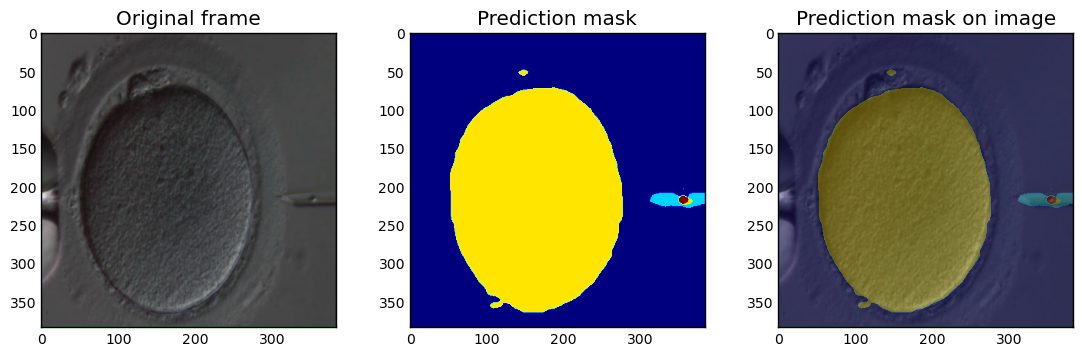

In [10]:
# 670 pęcherzyk powietrza

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Original frame')
plt.imshow(frames_to_test[360], vmin=0, vmax=3, cmap='gray')
plt.grid(False)
plt.subplot(232)
plt.title('Prediction mask')
plt.imshow(results[360], vmin=0, vmax=3, cmap='jet')
plt.grid(False)
plt.subplot(233)
plt.title('Prediction mask on image')
plt.imshow(frames_to_test[360], vmin=0, vmax=3, cmap='gray')
plt.imshow(results[360], vmin=0, vmax=3, cmap="jet", alpha=0.3)
plt.grid(False)
plt.show()

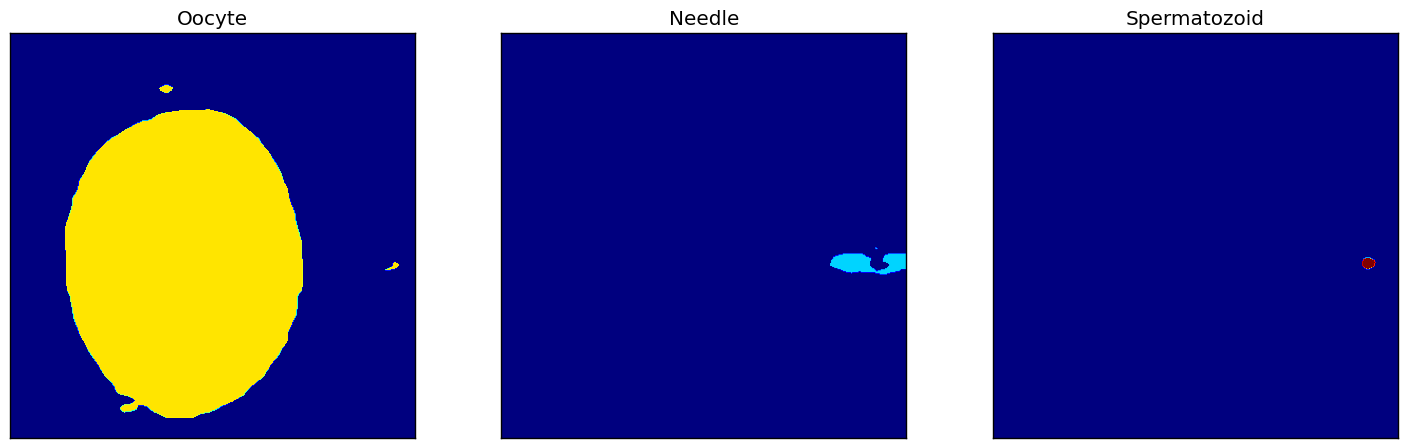

In [11]:
masks = [oocyte_mask, needle_mask, spermatozoid_mask]
classes = ['oocyte', 'needle', 'spermatozoid']

n = len(masks)
plt.figure(figsize=(16, 5))

for (i, mask) in enumerate(masks):
    plt.subplot(1, n, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.title(' '.join(classes[i].split('_')).title())
    plt.imshow(mask, vmin=0, vmax=3, cmap='jet')


In [48]:
count = 0
spermatozoid_masks = []
oocyte_masks = []
needle_masks = []
combined_masks = []

for i,m in zip(frames_to_test, preds):
  needle_mask = m.astype(np.uint8)
  needle_mask[needle_mask != 1] = 0
  needle_mask[needle_mask == 1] = 255
  needle_mask = np.stack((needle_mask,)*3, axis=-1)
  # needle_mask = cv2.applyColorMap(needle_mask, colormap=0)
  
  needle_masks.append(needle_mask)

  oocyte_mask = m.astype(np.uint8)
  oocyte_mask[oocyte_mask != 2] = 0
  oocyte_mask[oocyte_mask == 2] = 255
  oocyte_mask = np.stack((oocyte_mask,)*3, axis=-1)

  oocyte_masks.append(oocyte_mask)

  spermatozoid_mask = m.astype(np.uint8)
  spermatozoid_mask[spermatozoid_mask != 3] = 0
  spermatozoid_mask[spermatozoid_mask == 3] = 255
  spermatozoid_mask = np.stack((spermatozoid_mask,)*3, axis=-1)
  # spermatozoid_mask = cv2.applyColorMap(spermatozoid_mask, colormap=3)

  spermatozoid_masks.append(spermatozoid_mask)

  combined_mask = (oocyte_mask | needle_mask | spermatozoid_mask)
  combined_masks.append(combined_mask)
  # print(np.unique(combined_mask))

  dst = cv2.addWeighted(i, 0.5, oocyte_mask, 0.5, 0)
  dst = cv2.addWeighted(dst, 0.5, needle_mask, 0.5, 0)
  dst = cv2.addWeighted(dst, 0.5, spermatozoid_mask, 0.5, 0)
  # dst = cv2.bitwise_not(i,i, mask=mask)
  
  #dst = cv2.addWeighted(dst, 0.4, combined_mask, 0.6, 0)
  # dst = cv2.bitwise_not(i,i, mask=oocyte_mask)
  #dst = np.stack((oocyte_mask,)*3, axis=-1)

  cv2.imwrite(f'{directory}/test_results/frames_{str(count)}.png', dst)
  count += 1

In [49]:
print(len(oocyte_masks))
print(len(spermatozoid_masks))
print(len(needle_masks))
print(len(combined_masks))

871
871
871
871


In [50]:
def convert_frames_to_video(path):
        base_dir = os.path.realpath(path)
        print(base_dir)

        file_list = glob.glob(f'{base_dir}/*.png')  # Get all the pngs in the current directory
        file_list_sorted = natsorted(file_list,reverse=False)


        fps = 25

        clips = [ImageClip(m).set_duration(0.04)
                for m in file_list_sorted]

        concat_clip = concatenate_videoclips(clips, method="compose")
        concat_clip.write_videofile("test.mp4", fps=fps)

In [51]:
convert_frames_to_video('/media/madziegielewska/Seagate Expansion Drive/MAGISTERKA/diploma-project/Semantic-Segmentation/test_results')

/media/madziegielewska/Seagate Expansion Drive/MAGISTERKA/diploma-project/Semantic-Segmentation/test_results
Moviepy - Building video test.mp4.
Moviepy - Writing video test.mp4



Moviepy - Done !
Moviepy - video ready test.mp4
